### Importing The Packages

In [1]:
# Importing the liabraries
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, Input
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet50
#### EffecientNET B7
from tensorflow.keras.applications.efficientnet import EfficientNetB7
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.layers import GlobalAveragePooling2D, Input, concatenate
from tensorflow.keras.utils import to_categorical
import warnings
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from IPython.display import clear_output
from sklearn.model_selection import train_test_split
warnings.filterwarnings("ignore")
import cv2
from tqdm import tqdm
import glob
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix,classification_report,f1_score,ConfusionMatrixDisplay
import os
import pandas as pd

# if you dont have cuda enabled gpu in your system comment the lines below
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


2023-11-02 03:43:53.995431: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-02 03:43:54.194386: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-02 03:43:54.854659: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/aamir_z/anaconda3/envs/fvgpu/lib/python3.10/site-packages/nvidia/cudnn/lib:/home/aamir_z/anaconda3/envs/fvgpu/lib/:
2023-11-02 03:43:54.854804: W tensorflow/stream_executor/platform/default/dso_loader.cc:64

Num GPUs Available:  1


2023-11-02 03:43:55.651704: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-02 03:43:55.692952: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-02 03:43:55.693191: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


### Loading the dataset

In [2]:
# loading the datas
images = []
labels = []
# Location with subdirectories
path = "data_set"
# Get List of all images
files = glob.glob(path + '/**/*.jpeg', recursive=True)
# For each image
for file in  tqdm (files):
    img = cv2.imread(file)[:,:,::-1]
    img = cv2.resize(img,(224,224))
    #print(filename)
    images.append(img)
    y = file.split('/')[2]
    #print(y)
    labels.append(y)
images = np.array(images)
labels = np.array(labels)

100%|██████████| 15000/15000 [02:49<00:00, 88.74it/s]


### Data Analysis

In [3]:
# shape of images
print("Shape of Data = ", images.shape)

Shape of Data =  (15000, 224, 224, 3)


In [4]:
print("Shape of labels = ", labels.shape)

Shape of labels =  (15000,)


labels
colon_aca    3000
colon_n      3000
lung_scc     3000
lung_aca     3000
lung_n       3000
Name: count, dtype: int64


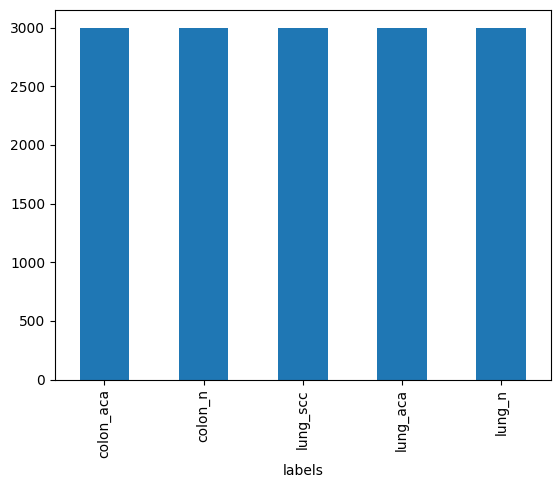

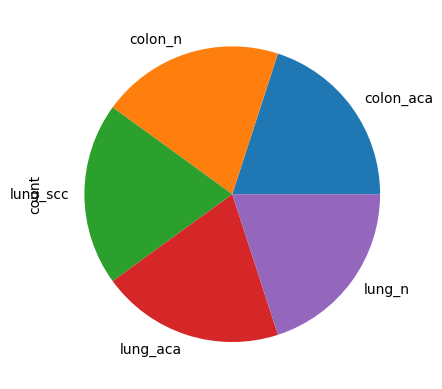

In [5]:
# storing the labels in the data frame
labels_df = pd.DataFrame(labels,columns=['labels'])

print(labels_df['labels'].value_counts())
plt.figure()
labels_df['labels'].value_counts().plot.bar()
plt.show()
plt.figure()
labels_df['labels'].value_counts().plot.pie()
plt.show()

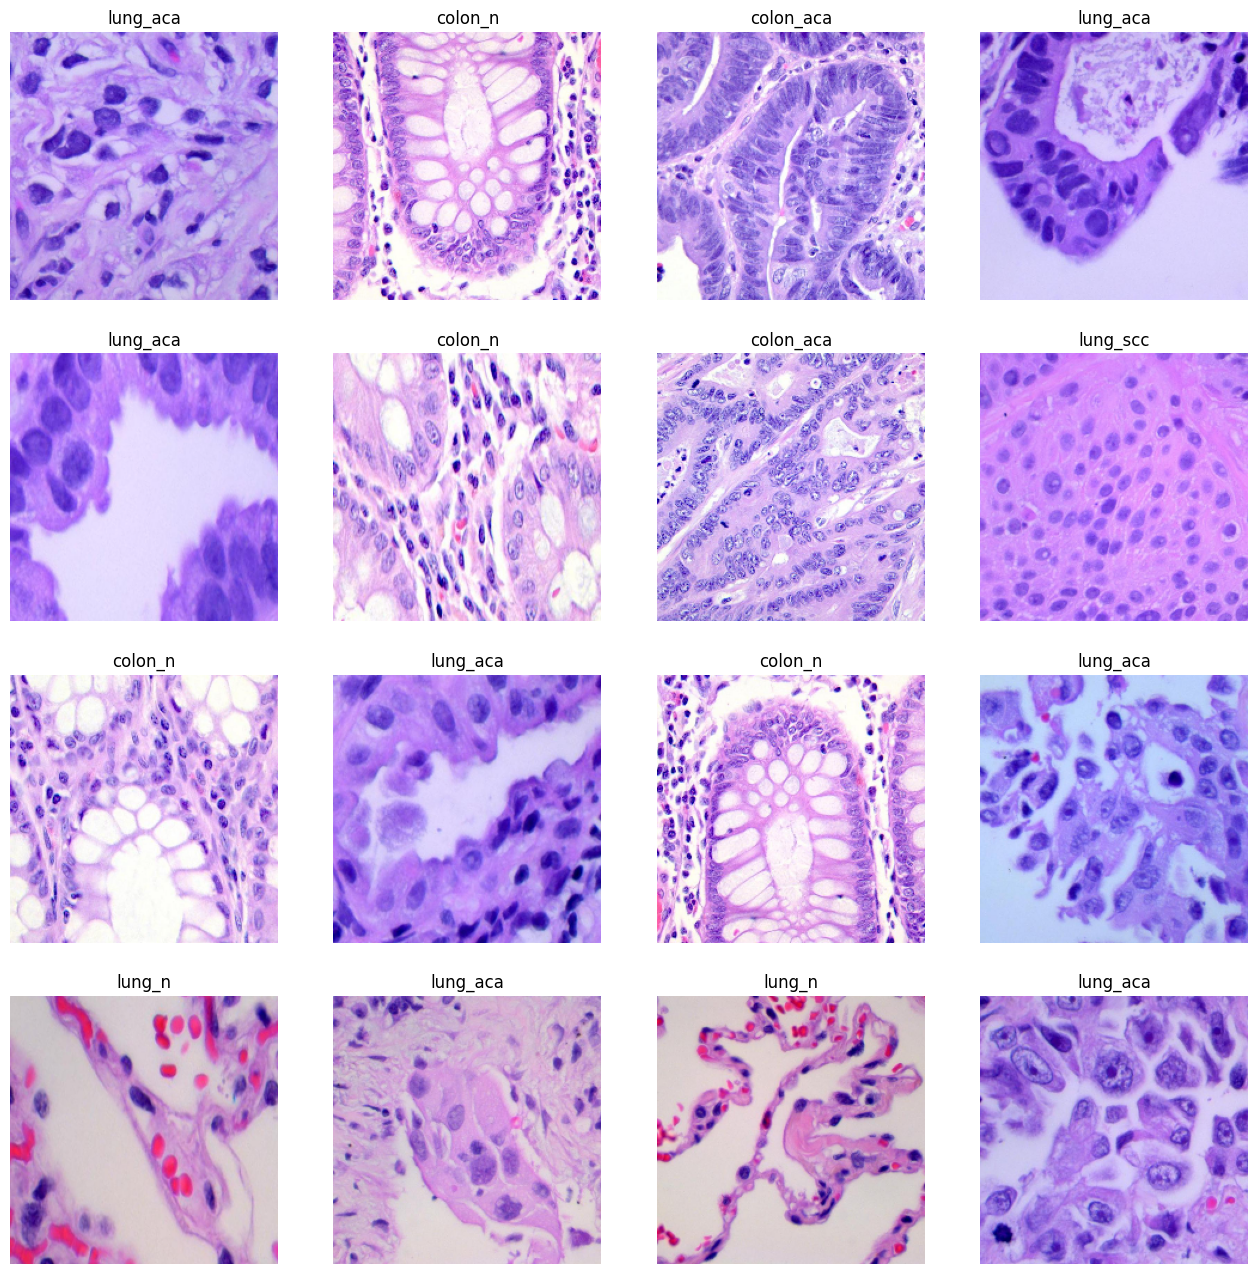

In [6]:
# This code will help you in visualizing mages
#np.random.seed(42)
plt.figure(1 , figsize = (16 , 16))

for n in range(1, 17):
    plt.subplot(4, 4, n)
    index = int(np.random.randint(0, images.shape[0], 1))
    plt.title(str(labels[index]))
    plt.imshow(images[index])
    plt.axis('off')

In [7]:
# loabel encoding of categorical features
le = LabelEncoder()
labels = le.fit_transform(labels)

# one hot encoding to feed it into model.
labels =to_categorical(labels)


In [8]:
#### Splitting the data
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.3, random_state=42)


### Deep Learning Models


In [9]:
class PlotLearning(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('accuracy'))
        self.val_acc.append(logs.get('val_accuracy'))
        self.i += 1
        f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
        
        clear_output(wait=True)
        
        ax1.set_yscale('log')
        ax1.plot(self.x, self.losses, label="loss")
        ax1.plot(self.x, self.val_losses, label="val_loss")
        ax1.legend()
        
        ax2.plot(self.x, self.acc, label="accuracy")
        ax2.plot(self.x, self.val_acc, label="validation accuracy")
        ax2.legend()
        
        plt.show();
        
accuracy_loss_plot = PlotLearning()

### Model 1 CNN

In [10]:
#creating sequential model
model=Sequential()
model.add(Conv2D(filters=64,kernel_size=2,padding="same",activation="relu",input_shape=(224,224,3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64,kernel_size=2,padding="same",activation="relu"))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=128,kernel_size=2,padding="same",activation="relu"))
model.add(MaxPooling2D(pool_size=2))


model.add(Flatten())

model.add(Dense(256,activation="relu"))
model.add(Dense(5,activation="softmax"))#2 represent output layer neurons 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      16448     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 128)       32896     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 128)      0

2023-11-02 03:46:47.907284: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-02 03:46:47.908257: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-02 03:46:47.908767: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-02 03:46:47.908956: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [11]:
# compiling the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

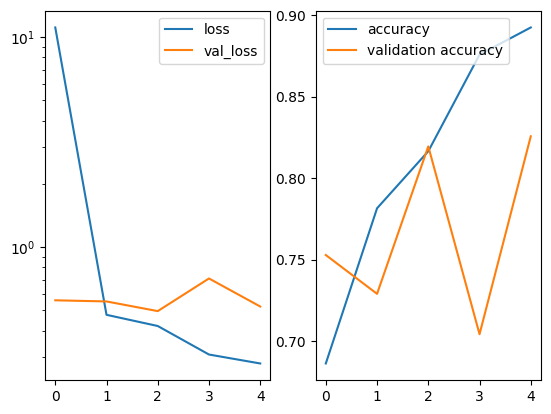

525/525 [==============================] - 23s 44ms/step - loss: 0.2787 - accuracy: 0.8925 - val_loss: 0.5207 - val_accuracy: 0.8257


In [12]:
#train the model with min batch size as 32 
history=model.fit(X_train,y_train,validation_split=0.2,epochs=5,batch_size=16, callbacks=accuracy_loss_plot)

#### Model Evaluation

In [13]:
### train performace 

In [14]:
y_pred = model.predict(X_train,batch_size=16)
y_pred = np.argmax(y_pred,axis=-1)
y_true = np.argmax(y_train,axis=-1)

2023-11-02 03:48:47.180243: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1580544000 exceeds 10% of free system memory.
2023-11-02 03:48:48.647030: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1580544000 exceeds 10% of free system memory.


657/657 [==============================] - 8s 12ms/step


              precision    recall  f1-score   support

           0       0.90      0.95      0.93      2097
           1       0.96      0.91      0.94      2089
           2       0.86      0.93      0.89      2092
           3       0.99      0.99      0.99      2128
           4       0.94      0.86      0.90      2094

    accuracy                           0.93     10500
   macro avg       0.93      0.93      0.93     10500
weighted avg       0.93      0.93      0.93     10500



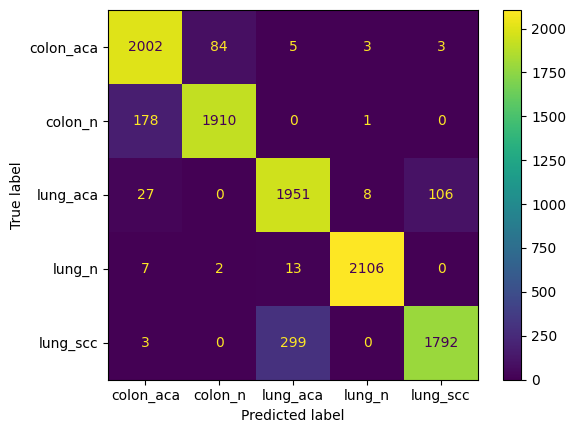

In [15]:
# print # classification Report
print(classification_report(y_true,y_pred))
cm = confusion_matrix(y_true,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=list(le.classes_))
disp.plot()
plt.show()

In [16]:
### test performace 

In [17]:
# get model predictions
y_pred = model.predict(X_test,batch_size=16)
y_pred = np.argmax(y_pred,axis=-1)
y_true = np.argmax(y_test,axis=-1)


282/282 [==============================] - 3s 12ms/step


              precision    recall  f1-score   support

           0       0.77      0.87      0.82       903
           1       0.85      0.76      0.80       911
           2       0.71      0.85      0.77       908
           3       0.98      0.94      0.96       872
           4       0.84      0.68      0.75       906

    accuracy                           0.82      4500
   macro avg       0.83      0.82      0.82      4500
weighted avg       0.83      0.82      0.82      4500



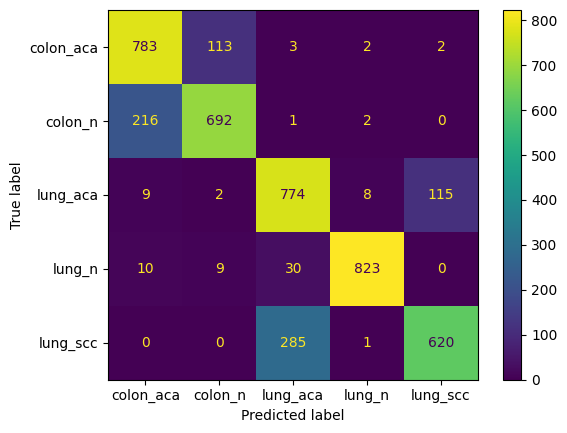

In [18]:
# print # classification Report
print(classification_report(y_true,y_pred))
cm = confusion_matrix(y_true,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=list(le.classes_))
disp.plot()
plt.show()

In [19]:
del(model)

### VGG 16

In [20]:
### initializing the model 
base_model = VGG16(include_top= False, weights= "imagenet", input_shape= (224,224,3), pooling= 'max')
base_model.trainable = False
model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(5, activation= 'softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 14,849,349
Trainable params: 133,637
Non-trainable params: 14,715,712
____________________________________

In [21]:
### compiling the model
model.compile(Adam(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

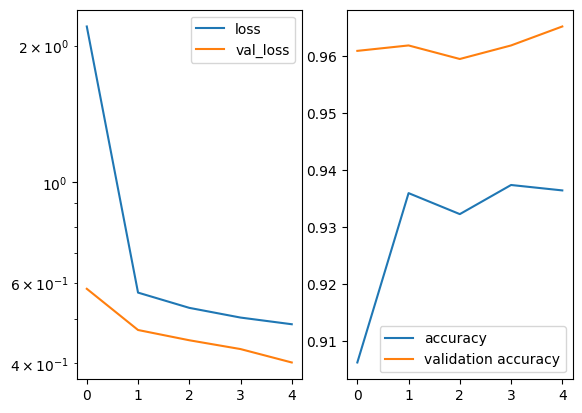

525/525 [==============================] - 40s 77ms/step - loss: 0.4877 - accuracy: 0.9364 - val_loss: 0.4019 - val_accuracy: 0.9652


In [22]:
history=model.fit(X_train,y_train,batch_size=16,validation_split=0.2,epochs=5,callbacks=accuracy_loss_plot)

In [23]:
### train performance

In [24]:
y_pred = model.predict(X_train,batch_size=16)
y_pred = np.argmax(y_pred,axis=-1)
y_true = np.argmax(y_train,axis=-1)

657/657 [==============================] - 39s 60ms/step


              precision    recall  f1-score   support

           0       0.97      0.99      0.98      2097
           1       1.00      0.98      0.99      2089
           2       0.98      0.90      0.94      2092
           3       1.00      1.00      1.00      2128
           4       0.91      0.98      0.95      2094

    accuracy                           0.97     10500
   macro avg       0.97      0.97      0.97     10500
weighted avg       0.97      0.97      0.97     10500



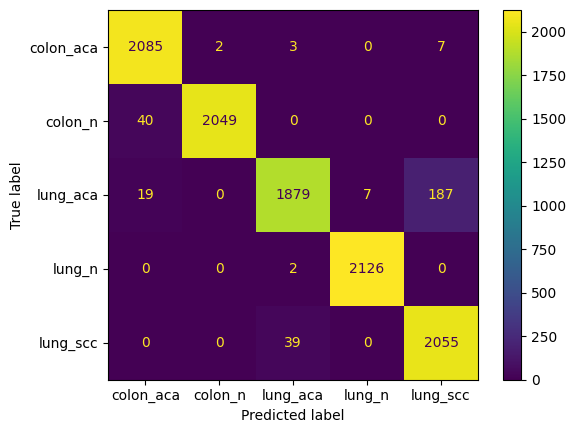

In [25]:
# print # classification Report
print(classification_report(y_true,y_pred))
cm = confusion_matrix(y_true,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=list(le.classes_))
disp.plot()
plt.show()

In [26]:
### test performace 

In [27]:
# get model predictions
y_pred = model.predict(X_test,batch_size=16)
y_pred = np.argmax(y_pred,axis=-1)
y_true = np.argmax(y_test,axis=-1)


282/282 [==============================] - 17s 60ms/step


              precision    recall  f1-score   support

           0       0.95      1.00      0.97       903
           1       1.00      0.96      0.98       911
           2       0.95      0.88      0.91       908
           3       0.99      0.99      0.99       872
           4       0.91      0.96      0.93       906

    accuracy                           0.96      4500
   macro avg       0.96      0.96      0.96      4500
weighted avg       0.96      0.96      0.96      4500



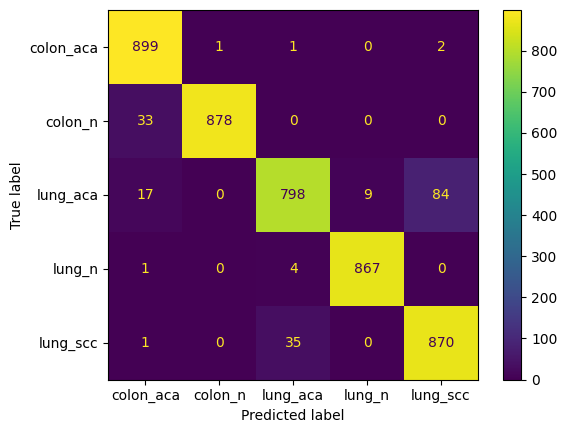

In [28]:
# print # classification Report
print(classification_report(y_true,y_pred))
cm = confusion_matrix(y_true,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=list(le.classes_))
disp.plot()
plt.show()

In [29]:
del(model)

### ResNet 50

In [30]:
### initializing the model 
base_model = ResNet50(include_top= False, weights= "imagenet", input_shape= (224,224,3), pooling= 'max')
base_model.trainable = False
model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(5, activation= 'softmax')
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 batch_normalization_1 (Batc  (None, 2048)             8192      
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 256)               524544    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 24,121,733
Trainable params: 529,925
Non-trainable params: 23,591,808
____________________________________

In [31]:
### compiling the model
model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

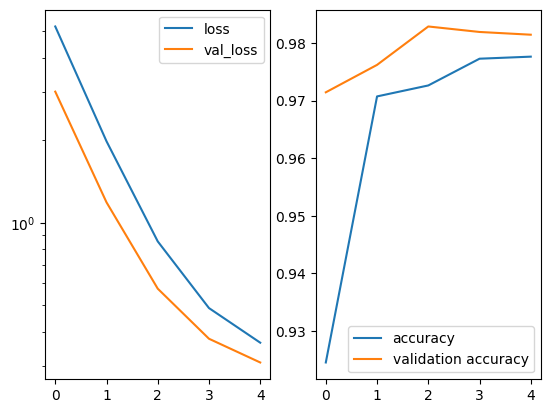

525/525 [==============================] - 33s 63ms/step - loss: 0.3642 - accuracy: 0.9776 - val_loss: 0.3083 - val_accuracy: 0.9814


In [32]:
history=model.fit(X_train,y_train,batch_size=16,validation_split=0.2,epochs=5,callbacks=accuracy_loss_plot)

In [33]:
### train performance

In [34]:
y_pred = model.predict(X_train,batch_size=16)
y_pred = np.argmax(y_pred,axis=-1)
y_true = np.argmax(y_train,axis=-1)

657/657 [==============================] - 32s 47ms/step


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2097
           1       1.00      1.00      1.00      2089
           2       0.99      0.97      0.98      2092
           3       1.00      1.00      1.00      2128
           4       0.97      0.99      0.98      2094

    accuracy                           0.99     10500
   macro avg       0.99      0.99      0.99     10500
weighted avg       0.99      0.99      0.99     10500



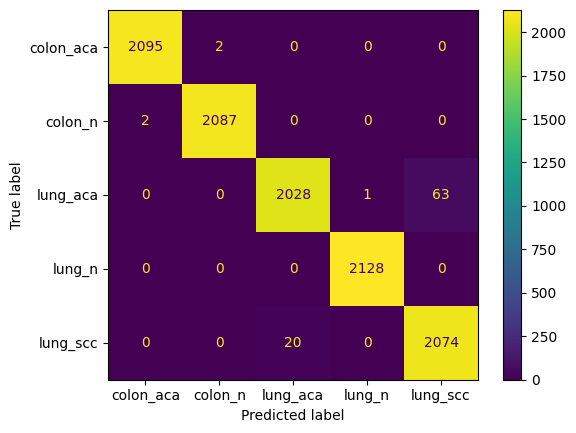

In [35]:
# print # classification Report
print(classification_report(y_true,y_pred))
cm = confusion_matrix(y_true,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=list(le.classes_))
disp.plot()
plt.show()

In [36]:
### test performace 

In [37]:
# get model predictions
y_pred = model.predict(X_test,batch_size=16)
y_pred = np.argmax(y_pred,axis=-1)
y_true = np.argmax(y_test,axis=-1)


282/282 [==============================] - 13s 45ms/step


              precision    recall  f1-score   support

           0       0.99      1.00      1.00       903
           1       1.00      0.99      1.00       911
           2       0.97      0.94      0.96       908
           3       1.00      1.00      1.00       872
           4       0.94      0.98      0.96       906

    accuracy                           0.98      4500
   macro avg       0.98      0.98      0.98      4500
weighted avg       0.98      0.98      0.98      4500



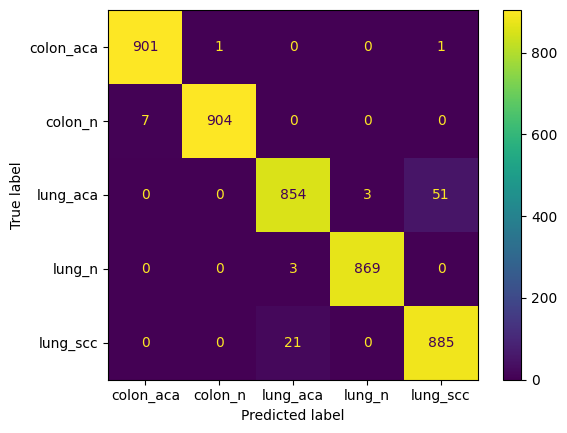

In [38]:
# print # classification Report
print(classification_report(y_true,y_pred))
cm = confusion_matrix(y_true,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=list(le.classes_))
disp.plot()
plt.show()

In [39]:
del(model)

### EfficientNetB7

In [40]:
### initializing the model 
base_model = EfficientNetB7(include_top= False, weights= "imagenet", input_shape= (224,224,3), pooling= 'max')
base_model.trainable = False
model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(5, activation= 'softmax')
])

In [41]:
### compiling the model
model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

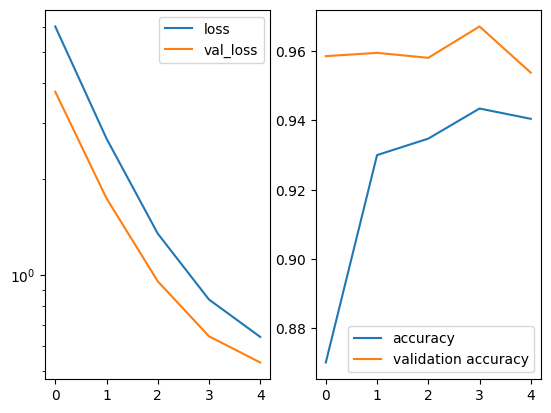

525/525 [==============================] - 130s 247ms/step - loss: 0.6413 - accuracy: 0.9405 - val_loss: 0.5334 - val_accuracy: 0.9538


In [42]:
history=model.fit(X_train,y_train,batch_size=16,validation_split=0.2,epochs=5,callbacks=accuracy_loss_plot)

In [43]:
### train performance

In [44]:
y_pred = model.predict(X_train,batch_size=16)
y_pred = np.argmax(y_pred,axis=-1)
y_true = np.argmax(y_train,axis=-1)

657/657 [==============================] - 133s 195ms/step


              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2097
           1       1.00      0.99      0.99      2089
           2       0.96      0.87      0.91      2092
           3       0.99      0.99      0.99      2128
           4       0.89      0.98      0.93      2094

    accuracy                           0.96     10500
   macro avg       0.97      0.96      0.96     10500
weighted avg       0.97      0.96      0.96     10500



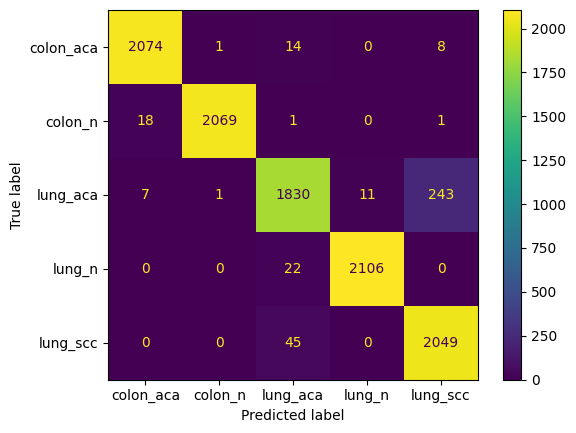

In [45]:
# print # classification Report
print(classification_report(y_true,y_pred))
cm = confusion_matrix(y_true,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=list(le.classes_))
disp.plot()
plt.show()

In [46]:
### test performace 

In [47]:
# get model predictions
y_pred = model.predict(X_test,batch_size=16)
y_pred = np.argmax(y_pred,axis=-1)
y_true = np.argmax(y_test,axis=-1)


282/282 [==============================] - 53s 187ms/step


              precision    recall  f1-score   support

           0       0.98      0.99      0.99       903
           1       1.00      0.99      0.99       911
           2       0.94      0.87      0.91       908
           3       0.99      0.99      0.99       872
           4       0.89      0.96      0.92       906

    accuracy                           0.96      4500
   macro avg       0.96      0.96      0.96      4500
weighted avg       0.96      0.96      0.96      4500



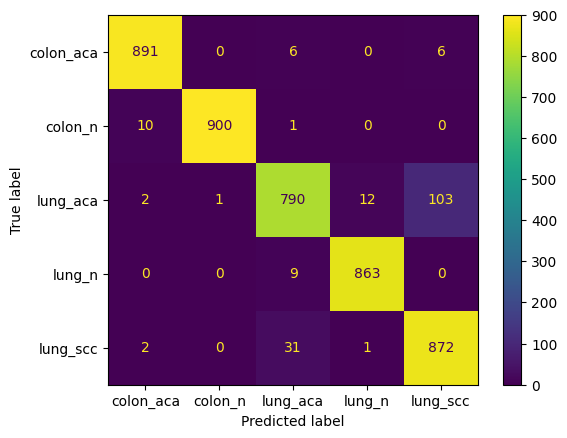

In [48]:
# print # classification Report
print(classification_report(y_true,y_pred))
cm = confusion_matrix(y_true,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=list(le.classes_))
disp.plot()
plt.show()